# Loan Prediction

Jan 20, 2022

Approving someone a loan is a risky business because it might never be returned. Thus, estimating whether a borrower is reliable enough is a very important task, if not the most important. The motivation for this project is to predict from data about a customer whether they should be lent money using machine learning algorithms.

This is a multiclass classification type of problem in which a subset of classifiers were trained from `scikit-learn`, and an `XGBoost` classifier. $F_1$ is used for a single number evaluation metric because the data set is imbalanced.

The most optimal model is the `XGBoost` classifier with default parameters with $F_1=0.9267$.

Technologies used in this project are: scikit-learn, XGBoost, Jupyter Notebook.

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score

%matplotlib inline
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

## Data Analysis

The data set can be accessed here: https://www.kaggle.com/zhijinzhai/loandata/version/1.

In [2]:
path = 'data\\'
df = pd.read_csv(path + 'Loan payments data.csv')
df.head()

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Loan_ID         500 non-null    object 
 1   loan_status     500 non-null    object 
 2   Principal       500 non-null    int64  
 3   terms           500 non-null    int64  
 4   effective_date  500 non-null    object 
 5   due_date        500 non-null    object 
 6   paid_off_time   400 non-null    object 
 7   past_due_days   200 non-null    float64
 8   age             500 non-null    int64  
 9   education       500 non-null    object 
 10  Gender          500 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 43.1+ KB


In [4]:
df.select_dtypes(np.number).shape[1], df.select_dtypes(np.object).shape[1]-1 # -1 beacuse target is categotical feature

(4, 6)

Four numerical features, and six categorical features.

In [5]:
df['loan_status'].value_counts()

PAIDOFF               300
COLLECTION            100
COLLECTION_PAIDOFF    100
Name: loan_status, dtype: int64

The data set is imbalanced.

| Data Set Info: |  |
| :--- | :--- |
| Number of features | 10 |
| Number of examples | 500 |
| Number of numerical features | 4 |
| Number of categorical features | 6 |
| Memory Usage | 43.1+ KB |
| Target | `loan_status` |
| ML Problem Type | Multiclass Classification |

In [6]:
df.isnull().sum()

Loan_ID             0
loan_status         0
Principal           0
terms               0
effective_date      0
due_date            0
paid_off_time     100
past_due_days     300
age                 0
education           0
Gender              0
dtype: int64

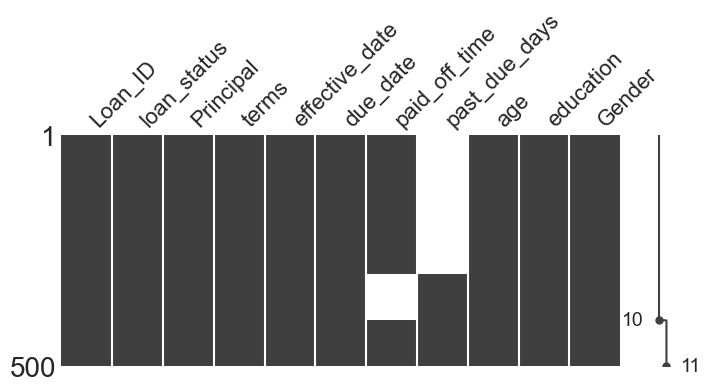

In [7]:
msno.matrix(df, figsize=(8,3))
plt.show()

- There are a lot of missing values in `past_due_days`, so we will drop it.
- We will impute the missing values in `paid_off_time` with $k$-Nearest Neighbors.

In [8]:
df.describe()

,Principal,terms,past_due_days,age
count,500.000000,500.000000,200.00000,500.000000
mean,943.200000,22.824000,36.01000,31.116000
std,115.240274,8.000064,29.38088,6.084784
min,300.000000,7.000000,1.00000,18.000000
25%,1000.000000,15.000000,3.00000,27.000000
50%,1000.000000,30.000000,37.00000,30.000000
75%,1000.000000,30.000000,60.00000,35.000000
max,1000.000000,30.000000,76.00000,51.000000


The data should be standardized, at least to aid model learning.

In [9]:
df.select_dtypes('object').describe()

,Loan_ID,loan_status,effective_date,due_date,paid_off_time,education,Gender
count,500,500,500,500,400,500,500
unique,500,3,7,25,320,4,2
top,xqd20166231,PAIDOFF,9/11/2016,10/10/2016,9/26/2016 9:00,college,male
freq,1,300,231,123,9,220,423


In [10]:
for column in df.select_dtypes('object').columns:
    unique_values = df.select_dtypes('object')[column].unique()
    number_values = len(unique_values)
    if number_values <= 10:
        print(f'Unique values for feature {column}: {number_values} -- {unique_values}')
    else:
        print(f'Unique values for feature {column}: {number_values}')

Unique values for feature Loan_ID: 500
Unique values for feature loan_status: 3 -- ['PAIDOFF' 'COLLECTION' 'COLLECTION_PAIDOFF']
Unique values for feature effective_date: 7 -- ['9/8/2016' '9/9/2016' '9/10/2016' '9/11/2016' '9/12/2016' '9/13/2016'
 '9/14/2016']
Unique values for feature due_date: 25
Unique values for feature paid_off_time: 321
Unique values for feature education: 4 -- ['High School or Below' 'Bechalor' 'college' 'Master or Above']
Unique values for feature Gender: 2 -- ['male' 'female']


- `Loan_ID` is a unique identifier for each borrower, so it can be dropped because it doesn't carry any useful information.
- `loan_status` is the target, and it has three classes: `'PAIDOFF`, `COLLECTION`, and `COLLECTION_PAIDOFF`.
- `effective_date`, `due_date`, and `paid_off_time` should be converted to datetime.
- `education` is an ordinal feature, meaning that there is ordering in the level of education, so ordinal encoding should be applied.
- `Gender` is a categorical feature, so one-hot encoding should be applied.

Cross tabulation.

In [11]:
pd.crosstab(index=df['education'], columns=df['loan_status'], margins=True)

loan_status,COLLECTION,COLLECTION_PAIDOFF,PAIDOFF,All
education,,,,
Bechalor,11,15,41,67
High School or Below,49,37,123,209
Master or Above,1,0,3,4
college,39,48,133,220
All,100,100,300,500


In [12]:
pd.crosstab(index=df['education'], columns=df['loan_status'], margins=True, normalize=True)*100

loan_status,COLLECTION,COLLECTION_PAIDOFF,PAIDOFF,All
education,,,,
Bechalor,2.2,3.0,8.2,13.4
High School or Below,9.8,7.4,24.6,41.8
Master or Above,0.2,0.0,0.6,0.8
college,7.8,9.6,26.6,44.0
All,20.0,20.0,60.0,100.0


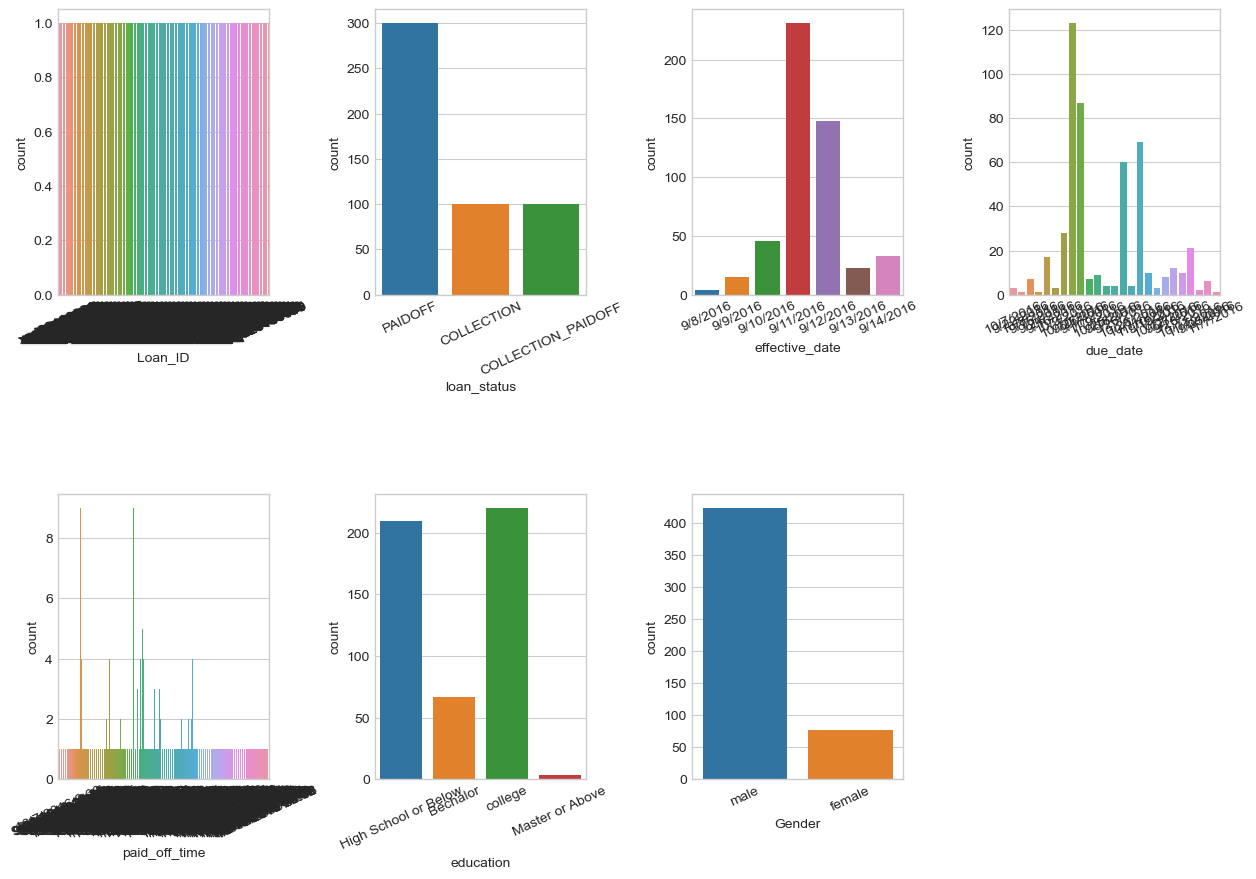

In [13]:
f = plt.figure(figsize=(15,10))
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.7)
for i, column in enumerate(df.select_dtypes('object').columns):
    ax = f.add_subplot(2, 4, i+1)
    sns.countplot(df[column])
    plt.xticks(rotation=25)

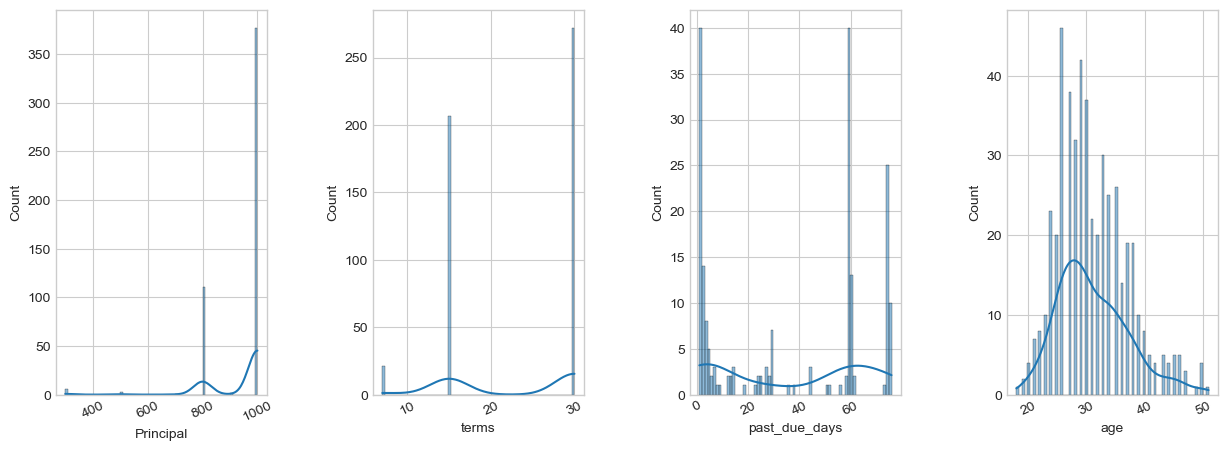

In [14]:
f = plt.figure(figsize=(15,5))
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
for i, column in enumerate(df.select_dtypes(np.number).columns):
    ax = f.add_subplot(1, 4, i+1)
    sns.histplot(df, x=df[column], kde=True, bins=70)
    plt.xticks(rotation=25)

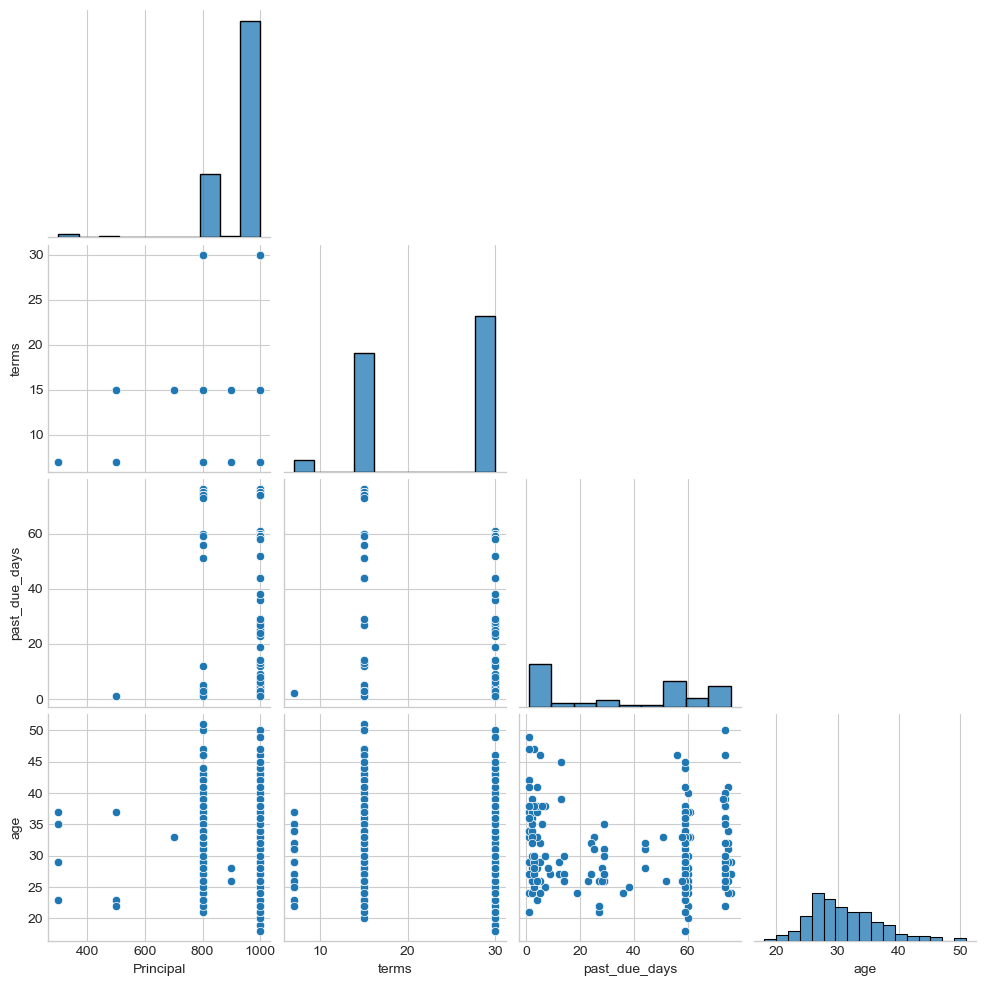

In [15]:
sns.pairplot(df, corner=True)
plt.show()

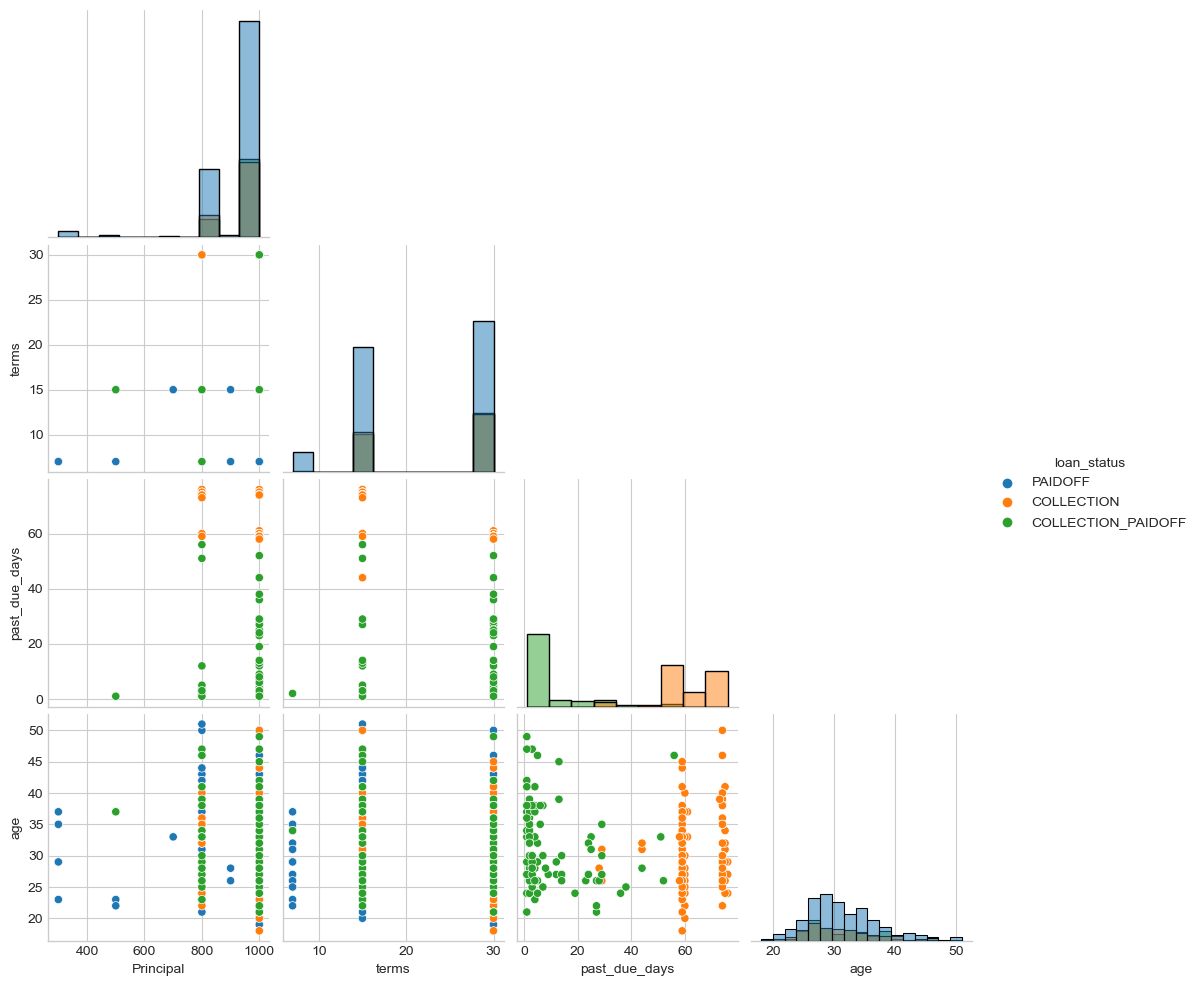

In [16]:
sns.pairplot(df, hue='loan_status', kind='scatter', diag_kind='hist', corner=True)
plt.show()

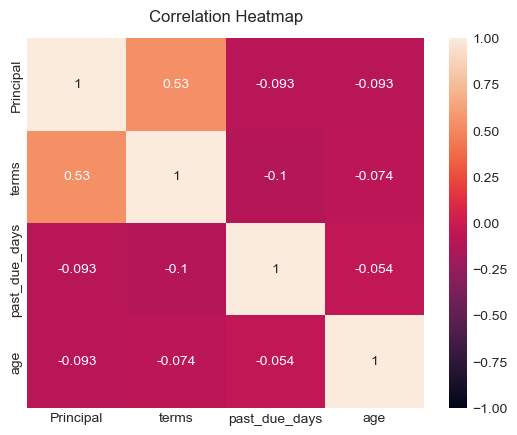

In [17]:
corr = df.corr()
sns.heatmap(corr, vmin=-1, vmax=1, annot=True).set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

## Preprocessing

In [18]:
def drop_features(df):
    df = df.copy()
    
    return df.drop(['Loan_ID', 'past_due_days'], axis=1)

In [19]:
def reformat(df):
    df = df.copy()
        
    # Convert to dateime
    for column in ['effective_date', 'due_date', 'paid_off_time']:
        df[column] = pd.to_datetime(df[column])
    
    df['effective_year'] = df['effective_date'].apply(lambda x: x.year)
    df['effective_month'] = df['effective_date'].apply(lambda x: x.month)
    df['effective_day'] = df['effective_date'].apply(lambda x: x.day)
    
    df['due_year'] = df['due_date'].apply(lambda x: x.year)
    df['due_month'] = df['due_date'].apply(lambda x: x.month)
    df['due_day'] = df['due_date'].apply(lambda x: x.day)
    
    df['paid_off_year'] = df['paid_off_time'].apply(lambda x: x.year)
    df['paid_off_month'] = df['paid_off_time'].apply(lambda x: x.month)
    df['paid_off_day'] = df['paid_off_time'].apply(lambda x: x.day)
    df['paid_off_hour'] = df['paid_off_time'].apply(lambda x: x.hour)
    
    df = df.drop(['effective_date', 'due_date', 'paid_off_time'], axis=1)
    
    return df

In [20]:
drop_feature = ['Loan_ID', 'past_due_days']
drop_transformer = FunctionTransformer(drop_features)

reformat_features = ['effective_date', 'due_date', 'paid_off_time']
reformat_transformer = Pipeline(
    [('reformat', FunctionTransformer(reformat)),
     ('imputer', KNNImputer()),
     ('scale', StandardScaler())]
     )

ordinal_feature = ['education']
ordinal_transformer = Pipeline(
    [('ordinal', OrdinalEncoder()),
     ('scale', StandardScaler())]
     )

categorical_feature = ['Gender']
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [('drop', drop_transformer, drop_feature),
     ('datetime', reformat_transformer, reformat_features),
     ('ordinal', ordinal_transformer, ordinal_feature),
     ('categorical', categorical_transformer, categorical_feature)],
     remainder=StandardScaler()
     )

In [21]:
le = LabelEncoder() # target

In [22]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

In [24]:
X_train.shape[0], X_test.shape[0]

(350, 150)

In [25]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [26]:
class_mappings = dict(zip(le.classes_, le.transform(le.classes_)))
class_mappings

{'COLLECTION': 0, 'COLLECTION_PAIDOFF': 1, 'PAIDOFF': 2}

In [27]:
le.inverse_transform(y_train)[0:10], y_train[0:10]

(array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
        'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object),
 array([2, 2, 2, 2, 2, 2, 2, 0, 2, 2]))

## Models

In [28]:
models = [
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    MLPClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

labels = [
    "   Logistic Regression",
    "Support Vector Machine",
    "         Decision Tree",
    "   Deep Neural Network",
    "         Random Forest",
    "               XGBoost"
]

for model in models:
    model.fit(X_train, y_train)

## Evaluation Metrics

In [29]:
F1_scores = []

for model, name in zip(models, labels):
    y_pred = model.predict(X_test)
    F1_score = f1_score(y_test, y_pred, average='micro')
    print(f'{name}: {F1_score}')
    F1_scores.append(F1_score)

F1_scores = np.asarray(F1_scores)

   Logistic Regression: 0.72
Support Vector Machine: 0.6866666666666666
         Decision Tree: 0.8266666666666667
   Deep Neural Network: 0.76
         Random Forest: 0.8866666666666667
               XGBoost: 0.9266666666666666


In [30]:
best_score = np.max(F1_scores)
best_estimator = models[F1_scores.argmax()]

print(f'Most optimal model is {best_estimator.__class__.__name__ } with F1 score = {best_score}')

Most optimal model is XGBClassifier with F1 score = 0.9266666666666666
